In [3]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def load_image(image_path):
    """Load an image and convert it to RGB format."""
    try:
        image = Image.open(image_path)
        return image.convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def overlay_mask(image, points):
    """Overlay a semi-transparent red mask on an image using given polygon points."""
    mask = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)
    points = [(int(x), int(y)) for x, y in points]
    draw.polygon(points, fill=(255, 0, 0, 128))  # Red semi-transparent mask
    return Image.alpha_composite(image.convert("RGBA"), mask).convert("RGB")

def wrap_text(text, font, max_width):
    """Wrap text to fit inside the given width."""
    lines = []
    words = text.split()
    current_line = []

    for word in words:
        test_line = current_line + [word]
        bbox = font.getbbox(" ".join(test_line))
        width = bbox[2] - bbox[0]

        if width <= max_width:
            current_line = test_line
        else:
            lines.append(" ".join(current_line))
            current_line = [word]

    lines.append(" ".join(current_line))
    return "\n".join(lines)

def plot_images(image_pairs, queries, title, font):
    """Plot images in a n x 3 layout with query text, RGB image, and RGB+mask image."""
    if not image_pairs:
        return

    n = len(image_pairs)
    fig, axes = plt.subplots(n, 3, figsize=(18, 5 * n))

    max_text_width = 300  # Max width for text

    for i, (rgb_image, image_with_mask) in enumerate(image_pairs):
        wrapped_text = wrap_text(queries[i], font, max_text_width)

        axes[i, 0].text(0.5, 0.5, wrapped_text, ha='center', va='center', fontsize=12, wrap=True)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(rgb_image)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(image_with_mask)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

def get_image_and_gt(image_name, gt_dir, image_dir):
    """Load an image and corresponding ground truth data."""
    image_path = os.path.join(image_dir, image_name + ".jpg")
    json_path = os.path.join(gt_dir, f"{image_name}.json")

    if not os.path.exists(json_path):
        print(f"Error: Ground truth file not found at {json_path}")
        return None, None, None

    with open(json_path) as f:
        gt = json.load(f)

    image = load_image(image_path)
    if image is None:
        return None, None, None

    points = gt['shapes'][0]['points']
    image_with_mask = overlay_mask(image, points)

    # Use only the first query
    query = gt['text'][0] if gt['text'] else "No query available"

    return image, image_with_mask, query

def get_random_image_pair(image_names, gt_dir, image_dir):
    """Select a random image from the dataset and return its pair."""
    image_name = random.choice(image_names)
    return get_image_and_gt(image_name, gt_dir, image_dir)

def load_image_names_from_txt(txt_file):
    """Load image names from a text file."""
    with open(txt_file) as f:
        return [line.strip() for line in f.readlines()]

def main(image_dir, gt_base_dir, n=5):
    train_dir = os.path.join(gt_base_dir, 'train')
    val_dir = os.path.join(gt_base_dir, 'val')
    test_dir = os.path.join(gt_base_dir, 'test')

    train_images_dir = './gres_images/train'
    val_images_dir = './gres_images/val'
    test_images_dir = './gres_images/test'

    # Modify paths for .txt files in ./gres_annotations folder
    train_txt = './gres_annotations/train/train.txt'
    val_txt = './gres_annotations/val/val.txt'
    test_txt = './gres_annotations/test/test.txt'

    # Load image names from the updated .txt file paths
    train_image_names = load_image_names_from_txt(train_txt)
    val_image_names = load_image_names_from_txt(val_txt)
    test_image_names = load_image_names_from_txt(test_txt)

    # Get random image pairs for each set
    train_pairs = [get_random_image_pair(train_image_names, train_dir, train_images_dir) for _ in range(n)]
    val_pairs = [get_random_image_pair(val_image_names, val_dir, val_images_dir) for _ in range(n)]
    test_pairs = [get_random_image_pair(test_image_names, test_dir, test_images_dir) for _ in range(n)]

    # Filter out invalid pairs
    train_pairs = [pair for pair in train_pairs if None not in pair]
    val_pairs = [pair for pair in val_pairs if None not in pair]
    test_pairs = [pair for pair in test_pairs if None not in pair]

    # Extract queries for each set
    train_queries = [pair[2] for pair in train_pairs]
    val_queries = [pair[2] for pair in val_pairs]
    test_queries = [pair[2] for pair in test_pairs]

    # Load font
    font = ImageFont.load_default()

    # Plot images and queries for each set
    print('\nTraining Samples')
    plot_images([pair[:2] for pair in train_pairs], train_queries, "Training Samples", font)
    print('\nValidation Samples')
    plot_images([pair[:2] for pair in val_pairs], val_queries, "Validation Samples", font)
    print('\nTest Samples')
    plot_images([pair[:2] for pair in test_pairs], test_queries, "Test Samples", font)



Training Samples


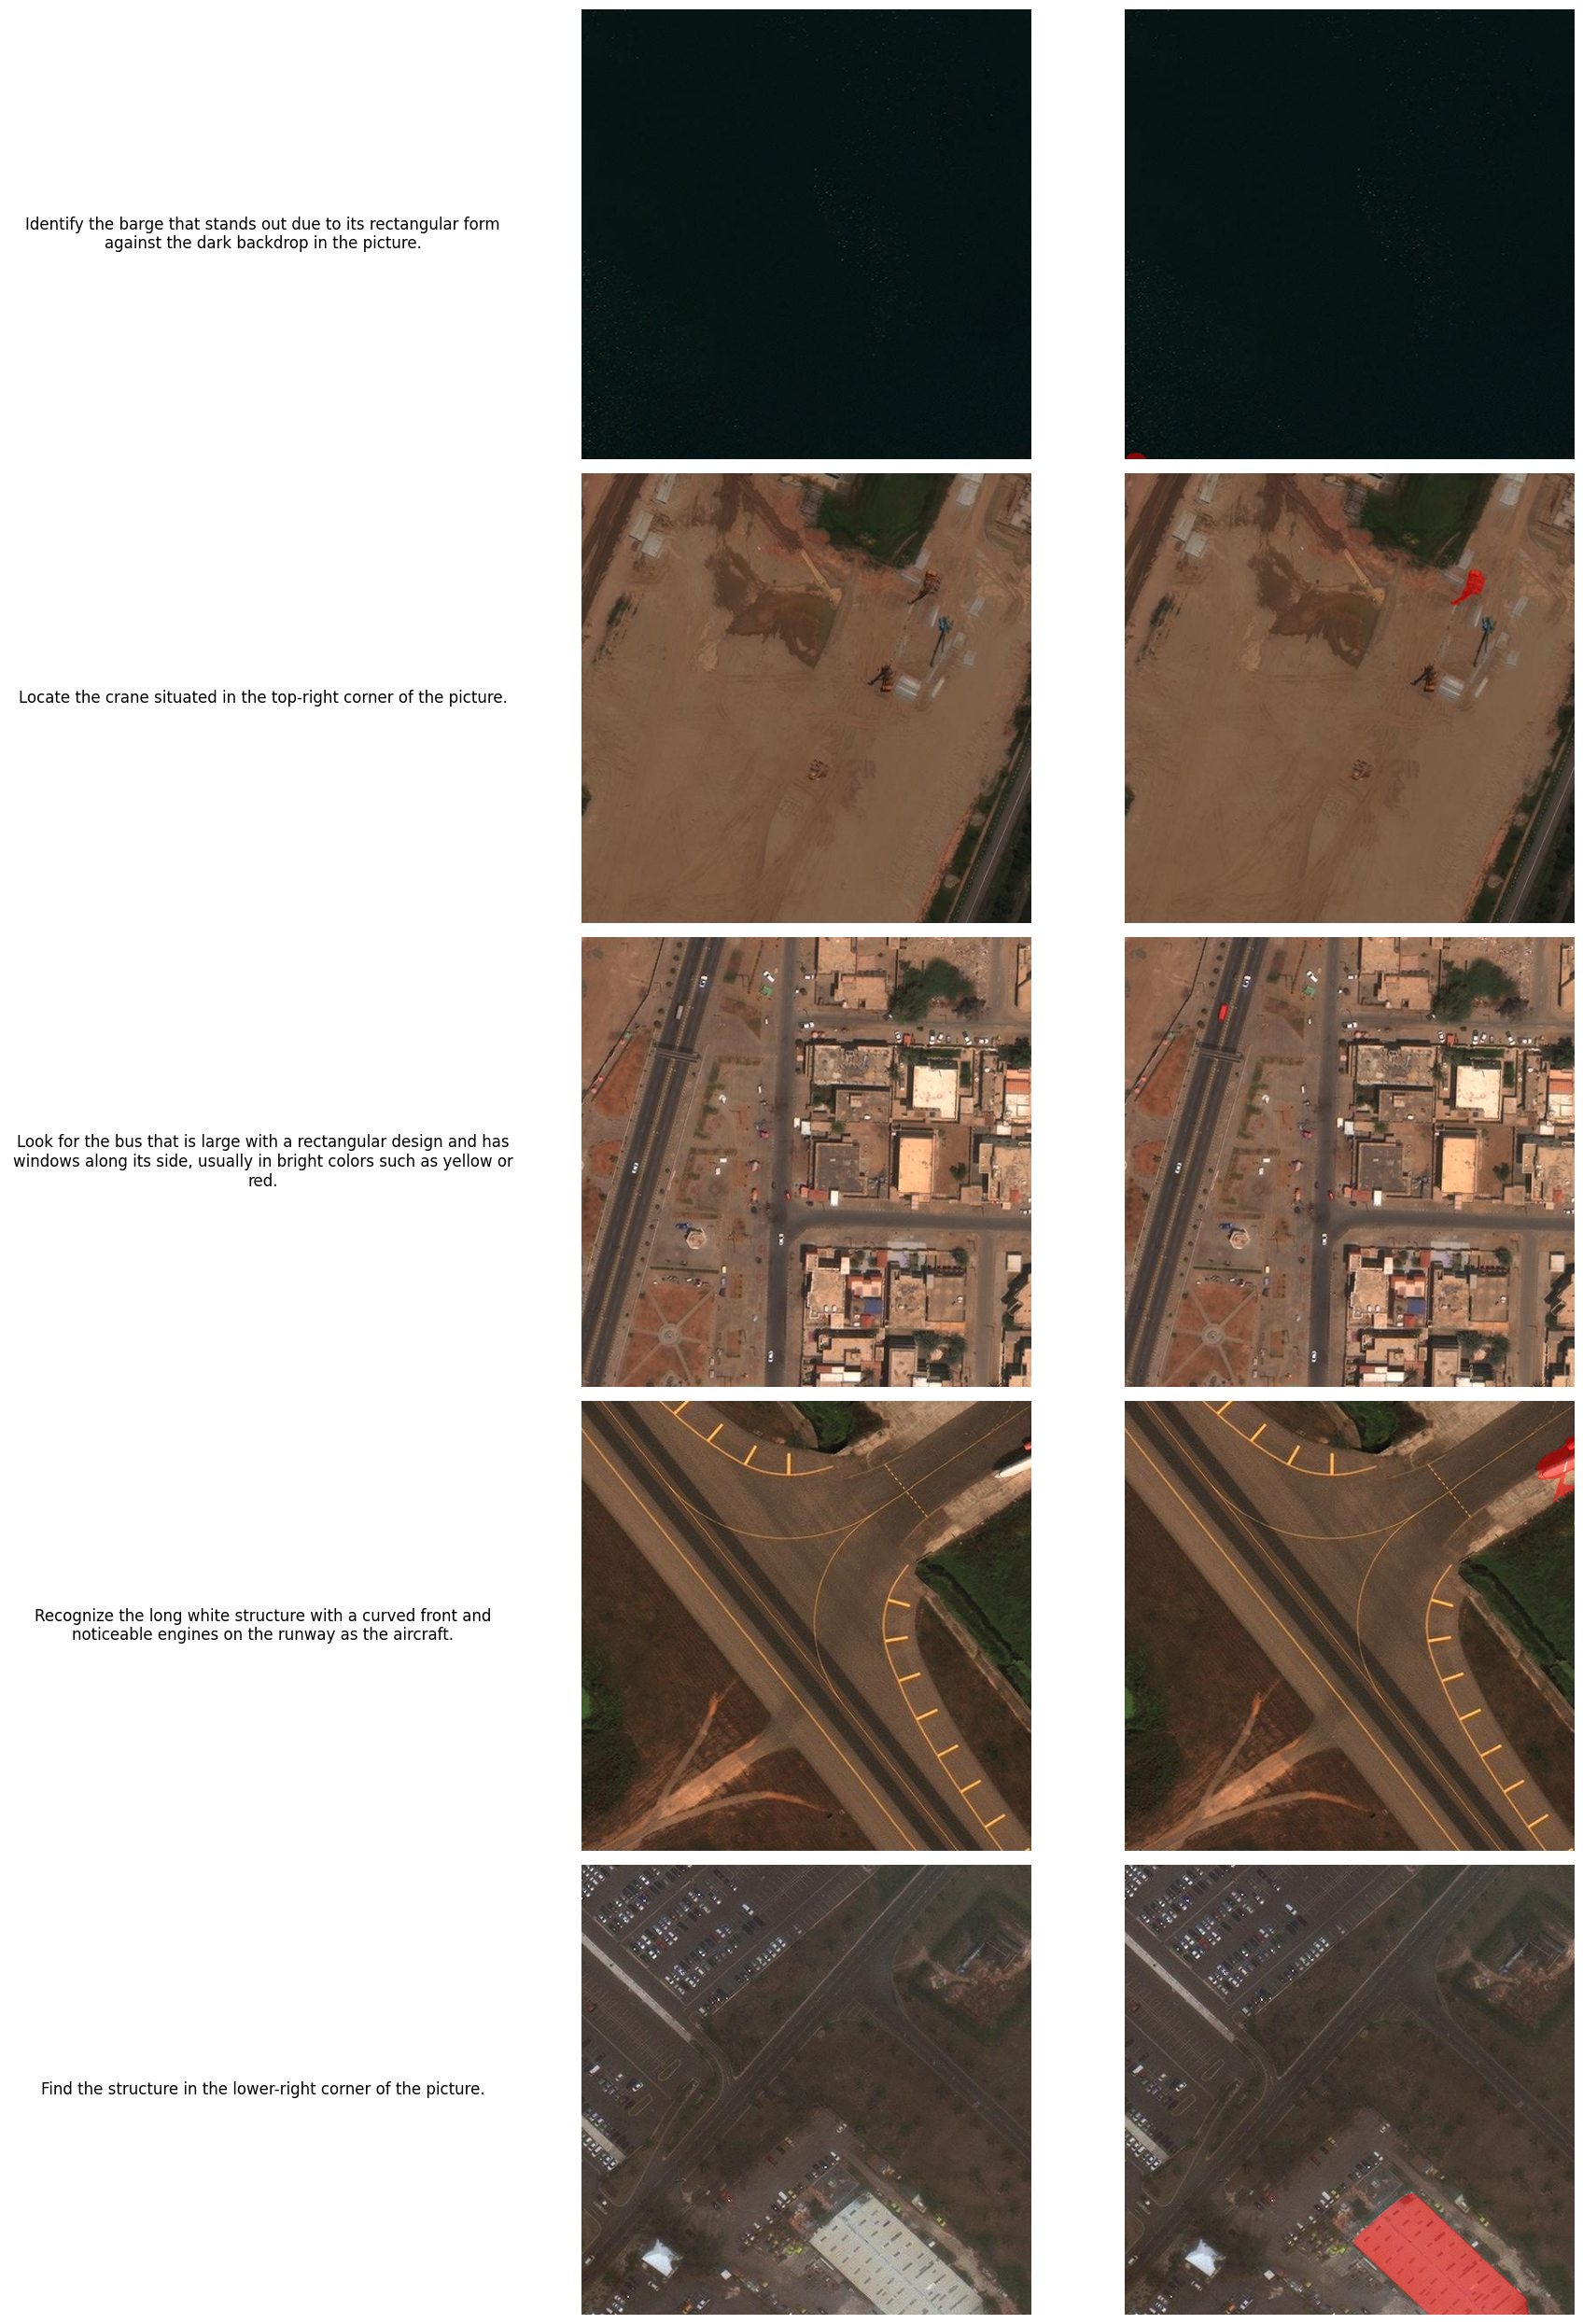


Validation Samples


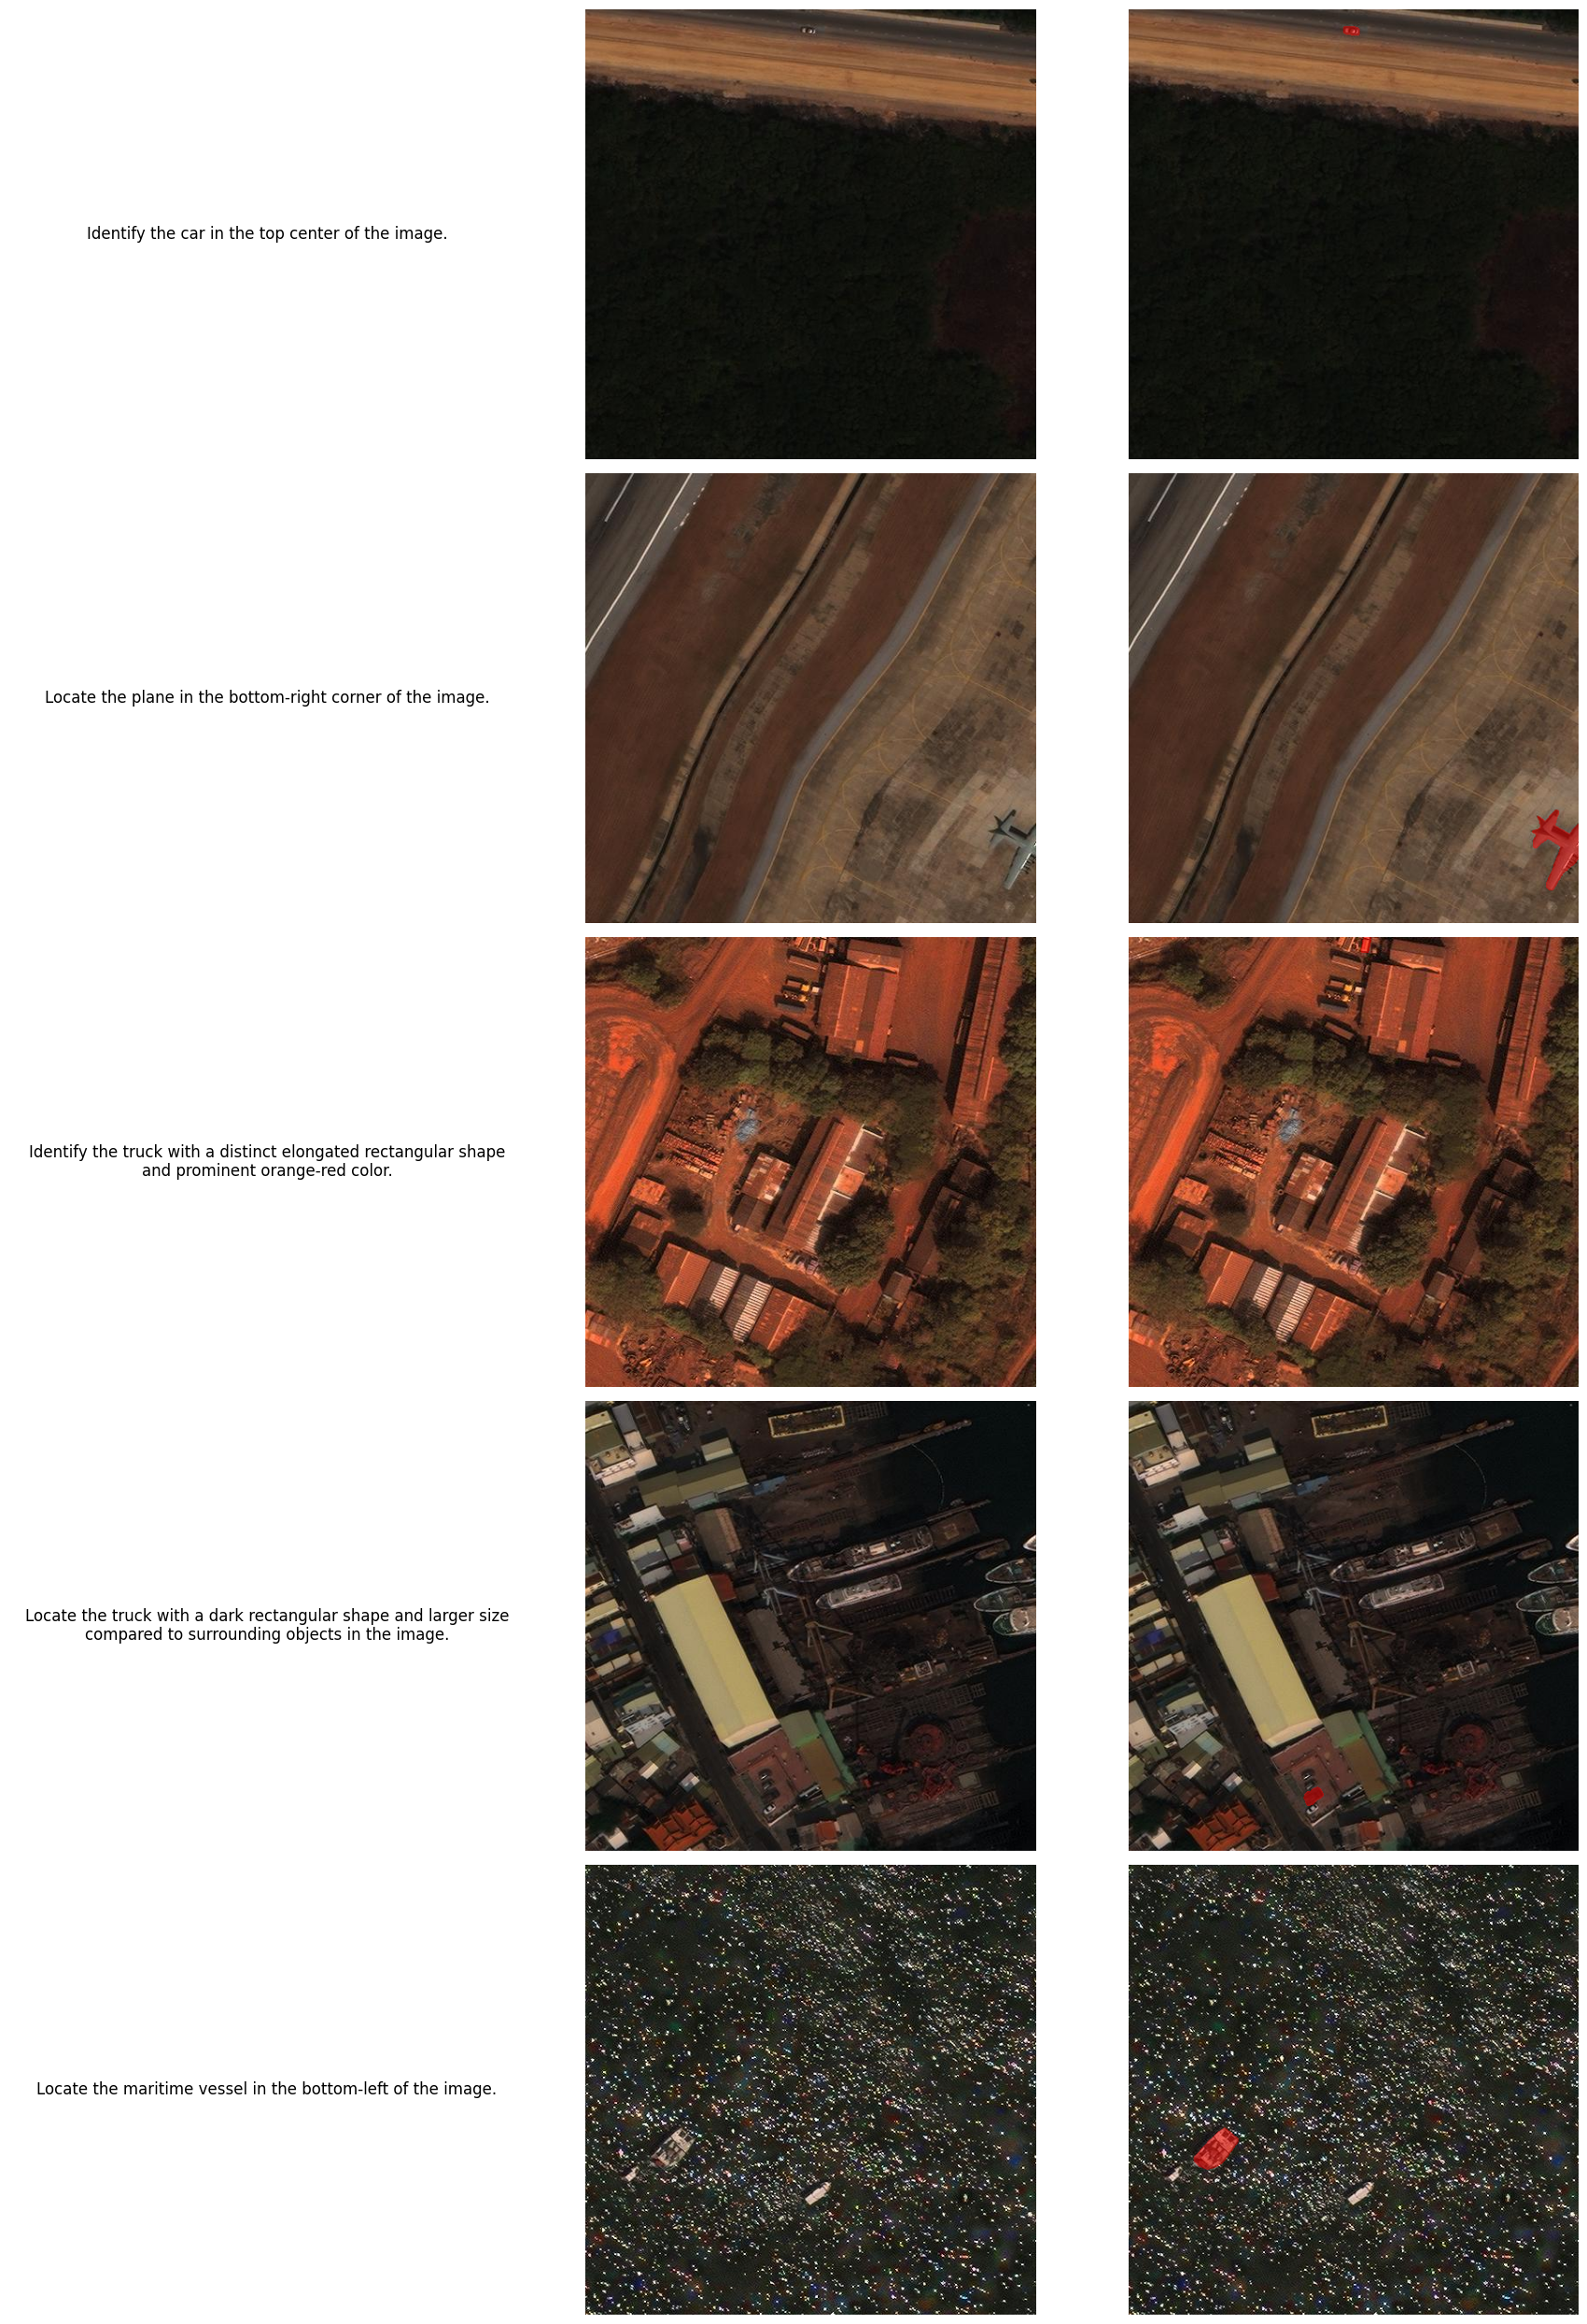


Test Samples


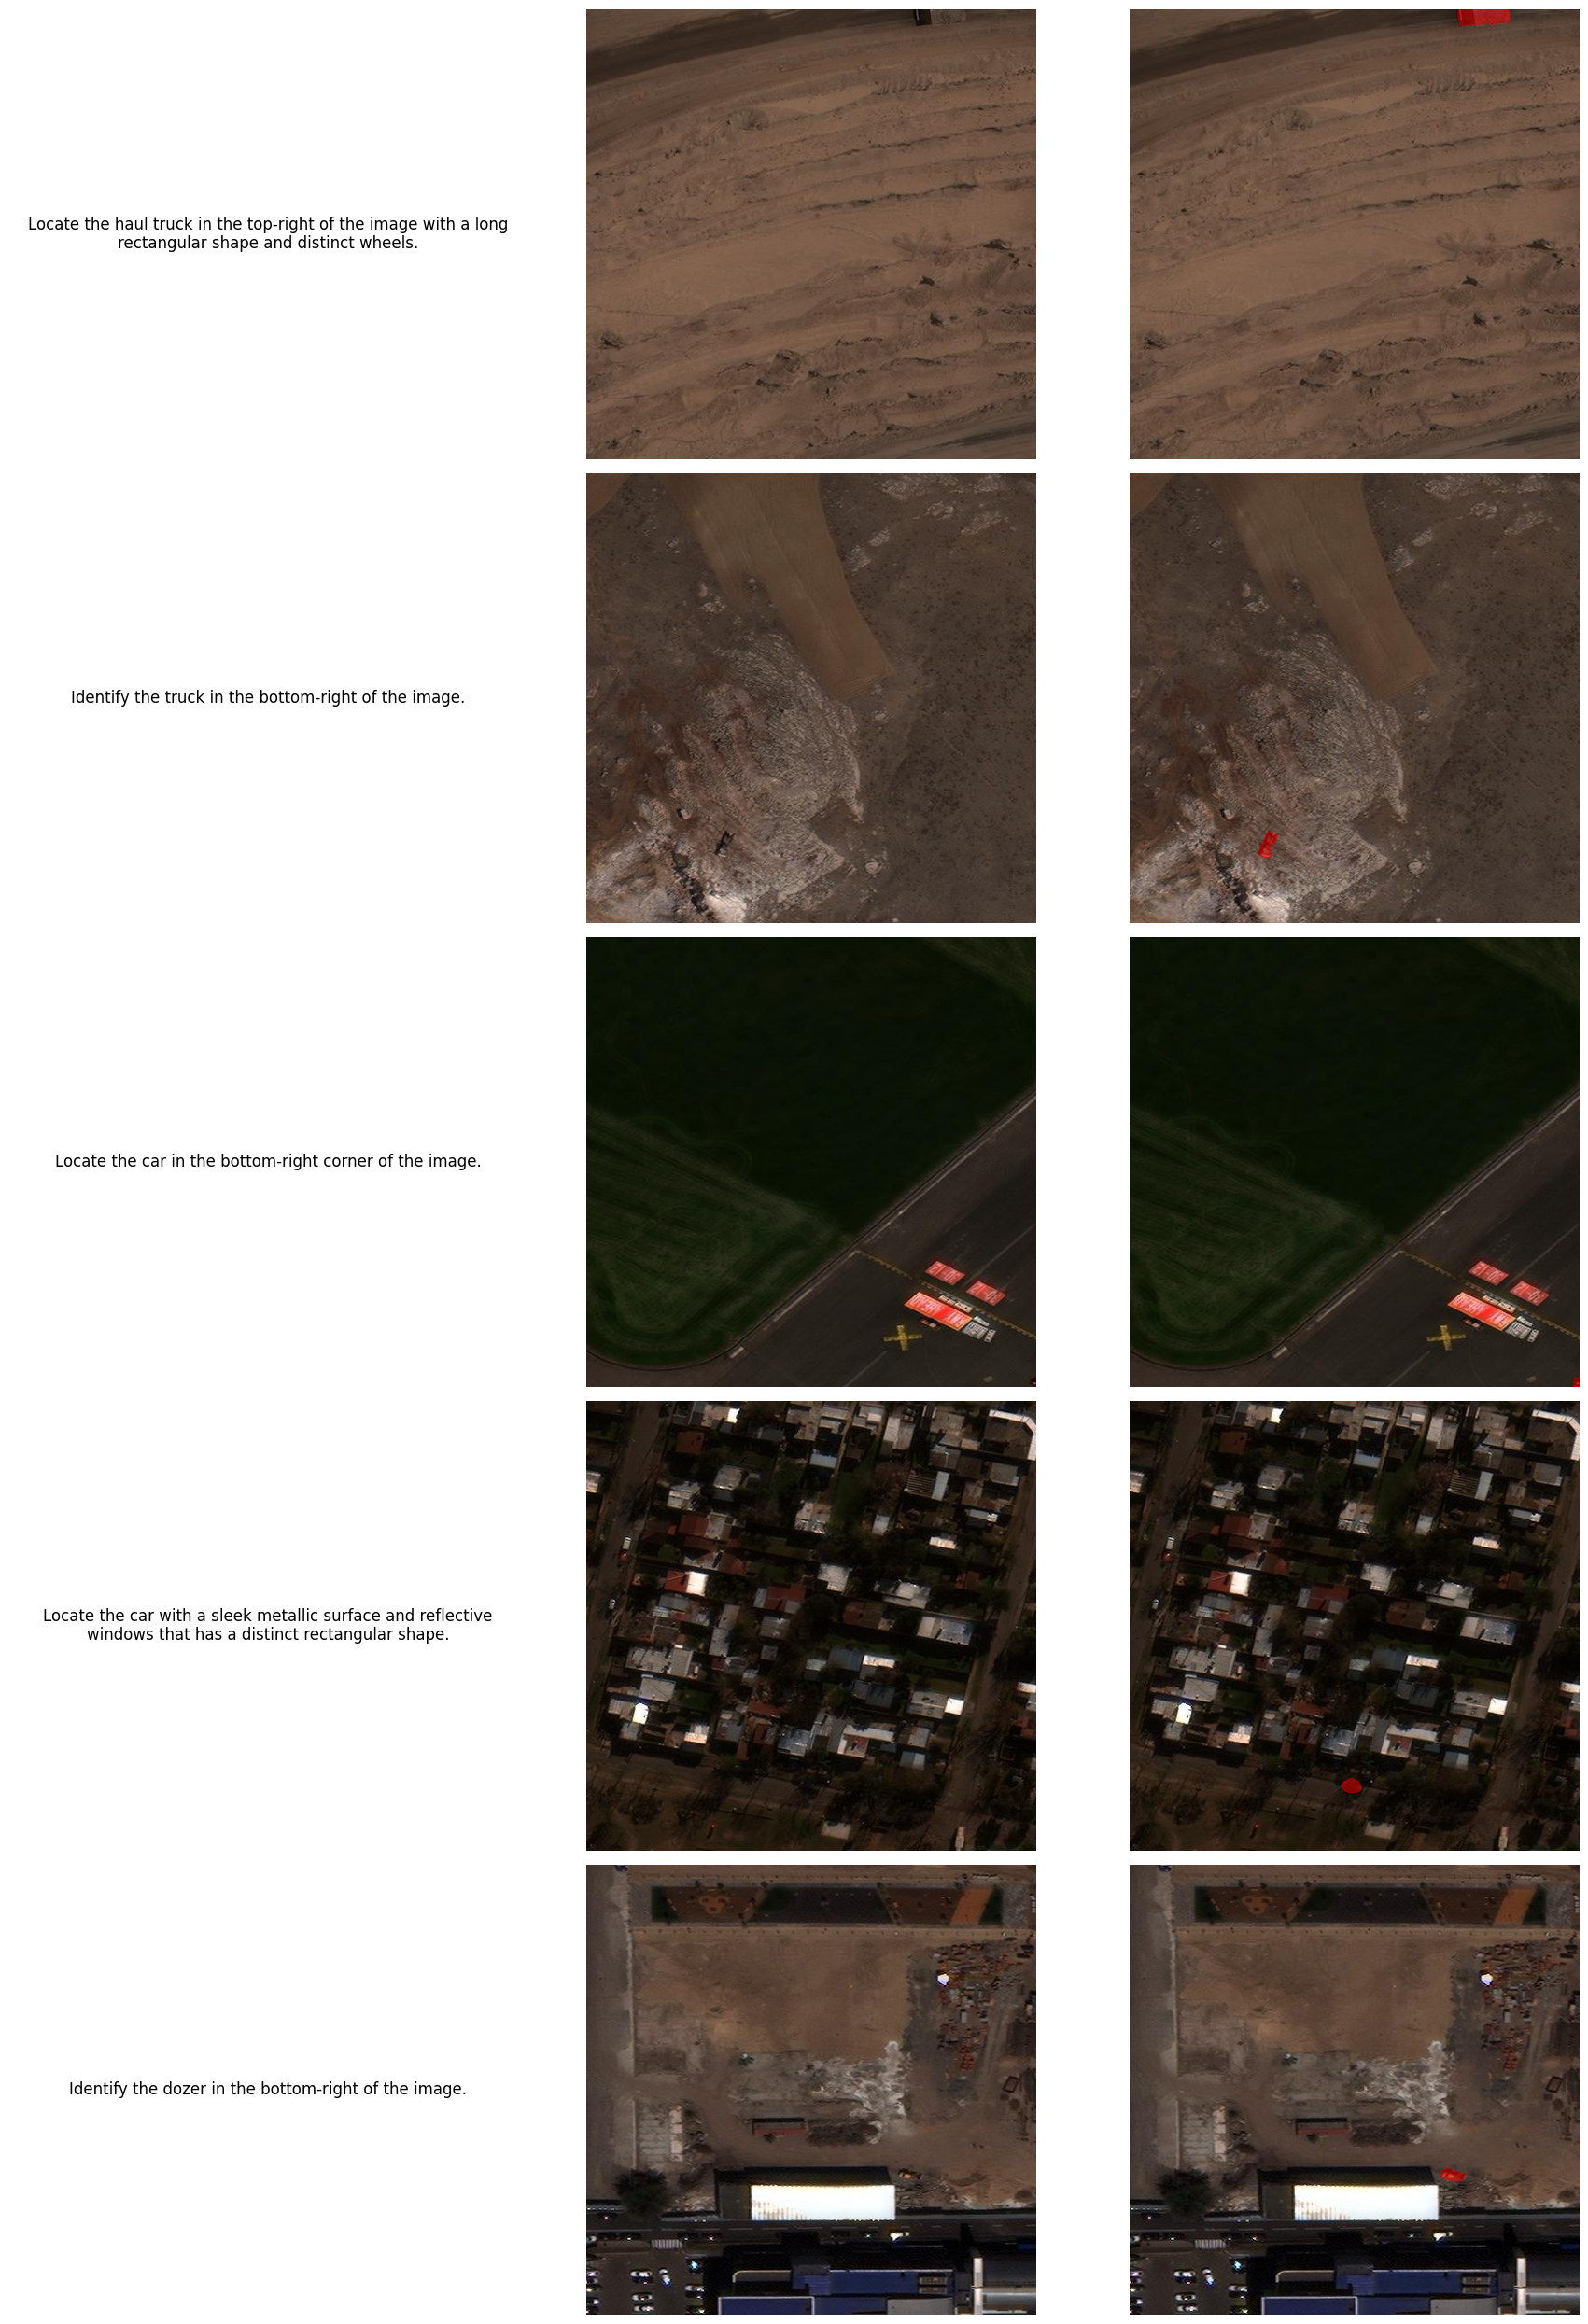

In [5]:
# Call the main function with the path to your image and GT directory
main('./gres_images', 'gres_annotations', n=5)